This notebook looks at how different saturation vapor pressure curves vary over the range of Kettle Ponds winter temperatures and the implications of that variation. We use SoS 5 and 30min tidy datasets.

In order, we
1. Define some saturation vapor pressure functions from the literature,
2. Calculate measured water vapor pressure from measured mixing ratio and atmopsheric pressure (adjusted for instrument height)
3. Analyze the sensitivity of water vapor pressure/specific humidity gradients to 1. choice of saturation vapor pressure curve and 2. choice of surface temperature measurement ()
4. Estimate surface temperature as 2 and/or 3-meter depoint temperature, see how well it does, and analyze sensitivity of water vapor pressure/specific humidity gradient 
5. Compare surface temperature measurements and the differences between them (i.e. apogee on tower c vs tower d , apogee on tower d to radiometer on tower d)

In [1]:
import os
import glob

import numpy as np
import scipy.stats
import pandas as pd
import pytz
import xarray as xr

import act
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

import datetime as dt

import seaborn as sns
from metpy.calc import saturation_vapor_pressure
from metpy.units import units

# Prerequisite files


* use script `analysis/sail/lidar_wind_profile_synoptic_wind_coherence.py` to download synoptic wind data
* use `cumulative_sublimation.ipynb` to create daily dataset
* use `analysis/sos/create_turbulence_dataset.ipynb` to create SoS tidy dataset and the (disdrometer) precip data

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230517'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Open Data 

#### SoS

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])


# Define saturation vapor pressure functions

Calculate saturation vapour pressure at the surface using our surface temperatures measurements.

1. Feld, S. I., Cristea, N. C. & Lundquist, J. D. Representing atmospheric moisture content along mountain slopes: Examination using distributed sensors in the Sierra Nevada, California. Water Resour. Res. 49, 4424–4441 (2013). (Equation A2)

Reportedly the "Magnus-Tetens formula", citing [Murray, 1967] with empirically updated coefficients [Alduchov and Eskridge, 1996]. "The formula... was found to err less than 0.4% for the temperature range of 40C–50C[Lawrence, 2005]:"

2. Teten's equation according to wikipedia, one for water and one for ice (https://en.wikipedia.org/wiki/Tetens_equation).

3. MetPy's equation, for which they cite a [Bolton, 1980] (https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.saturation_vapor_pressure.html).

In [4]:
# 1 
# returns in Pascals
def e_sat_feld(temp_in_c):
    return 610.94*np.exp(17.625*temp_in_c / (243.04 + temp_in_c))

# 2
# returns in Pascals
def e_sat_wiki(temp_in_c):
    kilopascals = None
    if temp_in_c <= 0:
        kilopascals = 0.61078*np.exp(17.27*temp_in_c / (237.3 + temp_in_c))    
    else:
        kilopascals = 0.61078*np.exp(21.875*temp_in_c / (265.5 + temp_in_c))    
    return kilopascals*1000

# 3
# returns in Pascals
def e_sat_metpy(temp_in_c):
    millibars = 6.112*np.exp(17.67*temp_in_c / (243.5 + temp_in_c))
    return millibars*100

# 4
# returns in Pascals
def e_sat_alduchov(temp_in_c):
    millibars = 6.1168*np.exp(22.587*temp_in_c / (273.86 + temp_in_c))
    return millibars*100

def e_sat_turbpy(temp_in_c):
    X1 = 17.27
    X2 = 237.30
    # Saturation water vapour pressure at 273.16K (Pa)
    SATVPFRZ = 610.8
    # Saturated Vapour Press (Pa)
    return SATVPFRZ * np.exp((X1 * temp_in_c) / (X2 + temp_in_c))

In [5]:
df = pd.DataFrame({'temperature': np.linspace(-40, 40, 81)})
df['e_sat_feld'] = df['temperature'].apply(e_sat_feld)
df['e_sat_wiki'] = df['temperature'].apply(e_sat_wiki)
df['e_sat_metpy'] = df['temperature'].apply(lambda t_in_c:
    saturation_vapor_pressure(t_in_c*units("degC")).magnitude      
)                         
df['e_sat_alduchov'] = df['temperature'].apply(e_sat_alduchov)
df['e_sat_turbpy'] = df['temperature'].apply(e_sat_turbpy)

<AxesSubplot: xlabel='temperature'>

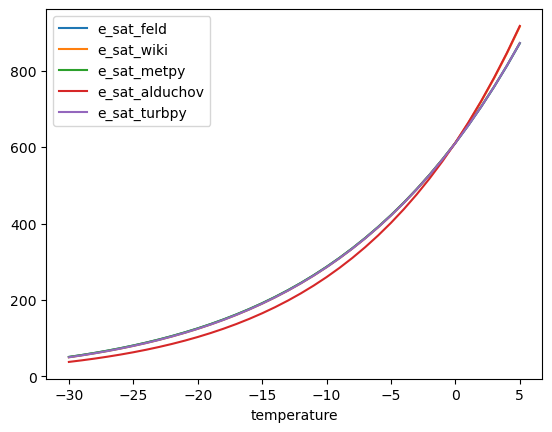

In [6]:
df.set_index("temperature")[-30:5].plot()

Text(0, 0.5, 'saturation vapor pressure (Pa)')

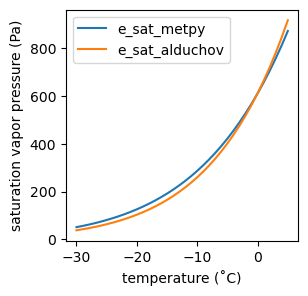

In [7]:
df.set_index("temperature")[-30:5][['e_sat_metpy', 'e_sat_alduchov']].plot(
    figsize=(3,3)
)
plt.xlabel("temperature (˚C)")
plt.ylabel("saturation vapor pressure (Pa)")

Text(0, 0.5, 'saturation vapor pressure (Pa)')

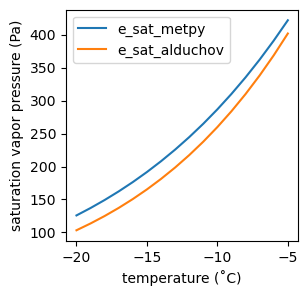

In [8]:
df.set_index("temperature")[-20:-5][['e_sat_metpy', 'e_sat_alduchov']].plot(
    figsize=(3,3)
)
plt.xlabel("temperature (˚C)")
plt.ylabel("saturation vapor pressure (Pa)")

In [9]:
vapor_pressure_df = tidy_df_30Min[tidy_df_30Min.time.dt.date == dt.date(2023, 1, 30)]
vapor_pressure_df = vapor_pressure_df[vapor_pressure_df.variable.isin(
    ['P_10m_c'] + 
    list(tidy_df_30Min[tidy_df_30Min.variable.str.startswith("T_")].variable.unique()) + 
    list(tidy_df_30Min[tidy_df_30Min.variable.str.startswith("Tsurf_")].variable.unique()) + 
    [v for v in vapor_pressure_df.variable.unique() if 'mixingratio' in v]
)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

vapor_pressure_df.columns

Index(['time', 'P_10m_c', 'T_10m_c', 'T_11m_c', 'T_12m_c', 'T_13m_c',
       'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c',
       'T_20m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c',
       'T_8m_c', 'T_9m_c', 'Tsurf_c', 'Tsurf_d', 'Tsurf_rad_d', 'Tsurf_ue',
       'Tsurf_uw', 'Tsurfmixingratio_c', 'Tsurfmixingratio_rad_d',
       'mixingratio_10m_c', 'mixingratio_11m_c', 'mixingratio_12m_c',
       'mixingratio_13m_c', 'mixingratio_14m_c', 'mixingratio_15m_c',
       'mixingratio_16m_c', 'mixingratio_17m_c', 'mixingratio_18m_c',
       'mixingratio_19m_c', 'mixingratio_20m_c', 'mixingratio_2m_c',
       'mixingratio_3m_c', 'mixingratio_4m_c', 'mixingratio_5m_c',
       'mixingratio_6m_c', 'mixingratio_7m_c', 'mixingratio_8m_c',
       'mixingratio_9m_c'],
      dtype='object', name='variable')

# Calculate water vapor pressure

In [11]:
from metpy.calc import vapor_pressure, add_height_to_pressure

In [12]:
vapor_pressure_df['Tsurfvaporpressure_c'] =   vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -10*units("m")
        ), row['Tsurfmixingratio_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_10m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 0*units("m")
        ),   row['mixingratio_10m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_11m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 1*units("m")
        ),   row['mixingratio_11m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_12m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 2*units("m")
        ),   row['mixingratio_12m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_13m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 3*units("m")
        ),   row['mixingratio_13m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_14m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 4*units("m")
        ),   row['mixingratio_14m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_15m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 5*units("m")
        ),   row['mixingratio_15m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_16m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 6*units("m")
        ),   row['mixingratio_16m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_17m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 7*units("m")
        ),   row['mixingratio_17m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_18m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 8*units("m")
        ),   row['mixingratio_18m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_19m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 9*units("m")
        ),   row['mixingratio_19m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_20m_c'] =        vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), 10*units("m")
        ),  row['mixingratio_20m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_2m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -8*units("m")
        ),  row['mixingratio_2m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_3m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -7*units("m")
        ),  row['mixingratio_3m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_4m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -6*units("m")
        ),  row['mixingratio_4m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_5m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -5*units("m")
        ),  row['mixingratio_5m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_6m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -4*units("m")
        ),  row['mixingratio_6m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_7m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -3*units("m")
        ),  row['mixingratio_7m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_8m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -2*units("m")
        ),  row['mixingratio_8m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)
vapor_pressure_df['vaporpressure_9m_c'] =         vapor_pressure_df.apply( 
    lambda row: vapor_pressure( 
        add_height_to_pressure(
            row['P_10m_c']*units("millibars"), -1*units("m")
        ),  row['mixingratio_9m_c']
    ).to(units("pascals")).magnitude, 
    axis=1
)

# Plot saturation vapor pressure functions and data from a day when MOST overpredicts sublimation

In [13]:
assert len(vapor_pressure_df.time.dt.date.unique()) == 1
(alt.Chart(df).transform_filter(
    (alt.datum.temperature <= -5)  & (alt.datum.temperature >= -10)
).transform_fold(
    ['e_sat_metpy', 'e_sat_alduchov'],
).mark_line().encode(
    alt.X("temperature:Q"),
    alt.Y("value:Q"),
    alt.Color('key:N')
) + alt.Chart(vapor_pressure_df[['time', 'T_3m_c', 'vaporpressure_3m_c']]).mark_circle().encode(
    alt.X("T_3m_c:Q").title("Temperature (˚C)"),
    alt.Y("vaporpressure_3m_c:Q").title("Vapor pressure (Pa)"),
    alt.Color('hours(time):Q').scale(scheme='turbo')
).properties(
    title = [f'Saturation vapor pressure curves and measured 3m',
             f'air temperature and humidity on {str(vapor_pressure_df.time.dt.date.iloc[0])}'
             ],
    width = 200, 
    height = 200
)).configure_legend(
    gradientLength=125,
).configure_title(
    anchor='start'
).display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Analyze sensitivity of specific humidity gradients to...

## Choice of saturation vapor pressure curve

In [15]:
DEFAULT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [16]:
from metpy.calc import specific_humidity_from_mixing_ratio

In [17]:
src = vapor_pressure_df.copy()
src['Surface e_sat, feld'] = src['Tsurf_c'].apply(e_sat_feld)
src['Surface e_sat, wiki'] = src['Tsurf_c'].apply(e_sat_wiki)
src['Surface e_sat, metpy'] = src['Tsurf_c'].apply(e_sat_metpy)
src['Surface e_sat, alduchov'] = src['Tsurf_c'].apply(e_sat_alduchov)
src['3m e'] = src['vaporpressure_3m_c']

In [18]:
src['Feld'] = (src['3m e'] - src['Surface e_sat, feld']) / 3
src['Metpy'] = (src['3m e'] - src['Surface e_sat, metpy']) / 3
src['Alduchov'] = (src['3m e'] - src['Surface e_sat, alduchov']) / 3

In [19]:
vars = ['Surface e_sat, feld', 'Surface e_sat, wiki', 'Surface e_sat, metpy', 'Surface e_sat, alduchov', '3m e']
alt.Chart(src).transform_fold(vars).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("key:N").title("Vapor pressure measurement").scale(
        domain = vars,
        range = DEFAULT_COLORS[:4] + ['#000000']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [20]:
vars = [
    'Feld',
    'Metpy',
    'Alduchov'
]
plot_dedz_satvappresscurve_sensitivity = alt.Chart(src).transform_fold(vars).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q").title('de/dz'),
    alt.Color("key:N").title("e_sat curve")
).properties(
    title = [
        'different e_sat curves (Tₛ from',
        'Tower C Apogee infrared sensor)'
    ],
    height = 200,
    width = 200
)
plot_dedz_satvappresscurve_sensitivity

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Choice of surface temperature measurement

In [21]:
src = vapor_pressure_df.copy()

src['Surface e_sat, apogee tower c'] = src['Tsurf_c'].apply(e_sat_metpy)
src['Surface e_sat, apogee tower d'] = src['Tsurf_d'].apply(e_sat_metpy)
src['Surface e_sat, radiometer tower d'] = src['Tsurf_rad_d'].apply(e_sat_metpy)
src['Surface e_sat, apogee tower ue'] = src['Tsurf_ue'].apply(e_sat_metpy)
src['Surface e_sat, apogee tower uw'] = src['Tsurf_uw'].apply(e_sat_metpy)
src['3m e'] = src['vaporpressure_3m_c']

In [22]:
src['Apogee tower c'] = (src['3m e'] - src['Surface e_sat, apogee tower c']) / 3
src['Apogee tower d'] = (src['3m e'] - src['Surface e_sat, apogee tower d']) / 3
src['Radiometer tower d'] = (src['3m e'] - src['Surface e_sat, radiometer tower d']) / 3
src['Apogee tower ue'] = (src['3m e'] - src['Surface e_sat, apogee tower ue']) / 3
src['Apogee tower uw'] = (src['3m e'] - src['Surface e_sat, apogee tower uw']) / 3

In [23]:
vars = ['Surface e_sat, apogee tower c', 'Surface e_sat, apogee tower d', 'Surface e_sat, radiometer tower d',
    'Surface e_sat, apogee tower ue', 'Surface e_sat, apogee tower uw', '3m e']
alt.Chart(src).transform_fold(vars).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("key:N").title("Vapor pressure measurement").scale(
        domain = vars, 
        range = DEFAULT_COLORS[:5] + ['#000000']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [24]:
vars = ['Apogee tower c', 'Apogee tower d', 'Radiometer tower d',
    'Apogee tower ue', 'Apogee tower uw']
plot_dedz_surftempmeasurement_sensitivity = alt.Chart(src).transform_fold(vars).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q").title('de/dz'),
    alt.Color("key:N").title("Temperature measurement")
).properties(
    title = [
        'different Tₛ measurements',
        '(using the MetPy e_sat curve)'
    ],
    height = 200,
    width = 200
)
plot_dedz_surftempmeasurement_sensitivity

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [25]:
src = tidy_df_30Min[tidy_df_30Min.time.dt.date == dt.date(2023, 3, 28)]
vars = [
    'w_h2o__3m_c',
    'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.0001)',
    'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.0005)',
    'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.001)',
    'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.005)'
]
alt.Chart(
    src[src.variable.isin(vars)]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable:N").scale(
        domain = vars, 
        range = ['#000000'] + DEFAULT_COLORS[:5]
    )
).configure_legend(labelLimit = 1000)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Examine how $T_d$ compares to $T_s$

In [26]:
from metpy.calc import dewpoint

In [27]:
vapor_pressure_df['Td_2m_c'] = vapor_pressure_df['vaporpressure_2m_c'].apply(lambda x: dewpoint(x * units("Pa")).magnitude)
vapor_pressure_df['Td_3m_c'] = vapor_pressure_df['vaporpressure_3m_c'].apply(lambda x: dewpoint(x * units("Pa")).magnitude)

In [28]:
alt.Chart(pd.DataFrame({'x': [-35,0], 'y': [-35,0]})).mark_line(color='grey').encode(x='x', y='y') + \
    alt.Chart(vapor_pressure_df).mark_circle(size=75).encode(
    alt.X("Tsurf_c:Q").scale(domain=[-35,0]),
    alt.Y("Td_2m_c:Q").scale(domain=[-35,0]),
    alt.Color("hours(time):Q").scale(scheme='turbo')
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [29]:
alt.Chart(vapor_pressure_df).transform_fold(
    ['Tsurf_c', 'Tsurf_rad_d', 'Td_2m_c', 'Td_3m_c']
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("key:N")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [30]:
src = vapor_pressure_df.copy()
src['3m e'] = src['vaporpressure_3m_c']
src['Surface e_sat, est from 2m T_d'] = src['Td_2m_c'].apply(e_sat_metpy)
src['Surface e_sat, apogee tower c'] = src['Tsurf_c'].apply(e_sat_metpy)
src['Estimate from 2m T_d'] = (src['3m e'] - src['Surface e_sat, est from 2m T_d']) / 3
src['Apogee tower c'] = (src['3m e'] - src['Surface e_sat, apogee tower c']) / 3

In [31]:
vars = ['Estimate from 2m T_d', 'Apogee tower c']
plot_dedz_tempestimate_sensitivity = alt.Chart(
    src
).transform_fold(
    vars
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('de/dz'),
    alt.Color("key:N").title("Surface temperature")
).properties(
    title = [
        'measured Tₛ (Tower C apogee) and',
        'Tₛ estimated as 2m dewpoint temp. '
    ],
    height = 200,
    width = 200
)
plot_dedz_tempestimate_sensitivity

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [32]:
(plot_dedz_satvappresscurve_sensitivity | plot_dedz_surftempmeasurement_sensitivity | plot_dedz_tempestimate_sensitivity).resolve_scale(
    y = 'shared', x = 'shared', color='independent'

).configure_legend(orient = 'top', columns = 2).properties(title='de/dz calculated using...')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [65]:
src = tidy_df_30Min[
    tidy_df_30Min.variable.isin([
        'Tsurf_c',
        'Tsurf_d',
        'Tsurf_rad_d',
        'w_h2o__3m_c',
        'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.0001)',
    ])
].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index().rename(columns={
    'w_h2o__3m_c predicted (turbpy MO Webb NoahMP andreas lengths 0.0001)':  'w_h2o__3m_c predicted'
})
src

variable,time,Tsurf_c,Tsurf_d,Tsurf_rad_d,w_h2o__3m_c,w_h2o__3m_c predicted
0,2022-11-29 17:00:00,-13.768946,-18.565422,-16.073145,0.001584,9.874750e-04
1,2022-11-29 17:30:00,-14.258275,-21.847244,-18.897799,0.001530,1.278563e-03
2,2022-11-29 18:00:00,-14.880508,-23.378464,-20.045730,-0.000297,4.804837e-04
3,2022-11-29 18:30:00,-16.704226,-26.126198,-22.366542,0.000404,-7.178188e-17
4,2022-11-29 19:00:00,-18.104375,-27.533277,-23.935929,-0.000359,-1.132640e-16
...,...,...,...,...,...,...
7978,2023-05-17 15:30:00,18.878118,9.402761,NaN,0.033596,NaN
7979,2023-05-17 16:00:00,17.034668,8.803223,NaN,0.029292,NaN
7980,2023-05-17 16:30:00,16.117884,8.696416,NaN,0.025573,NaN
7981,2023-05-17 17:00:00,13.426503,7.459737,NaN,0.025568,NaN


In [66]:
(alt.Chart(
    pd.DataFrame({'x':[-35,20], 'y':[-35,20]})
).mark_line(color='grey').encode(x='x',y='y') + \
alt.Chart(src).mark_circle(size=25).encode(
    alt.X("Tsurf_d").scale(domain = [-35,20]).title("Apogee T_s, tower d"),
    alt.Y("Tsurf_c").scale(domain = [-35,20]).title("Apogee T_s, tower c"),
)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [67]:
src['temp error'] = src['Tsurf_d'] - src['Tsurf_c']
src['temp error'].min(), src['temp error'].max(), src['temp error'].mean(), src['temp error'].median()

(-24.31896464029948,
 82.82486979166666,
 -0.527167515701731,
 0.015674591064451793)

In [68]:
alt.Chart(src[src['temp error'] < 80]).mark_bar().encode(
    alt.X("temp error:Q").bin(maxbins = 75).title('(Apogee surface temp) − (Radiometer surface temp)'),
    alt.Y("count():Q"),
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [69]:
(alt.Chart(
    pd.DataFrame({'x':[-35,5], 'y':[-35,5]})
).mark_line(color='grey').encode(x='x',y='y') + \
alt.Chart(src).mark_circle(size=25).encode(
    alt.X("Tsurf_d").scale(domain = [-35,5]).title("Apogee surface temp"),
    alt.Y("Tsurf_rad_d").scale(domain = [-35,5]).title("Radiometer surface temp")
)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [70]:
src['temp error'] = src['Tsurf_d'] - src['Tsurf_rad_d']
src['temp error'].min(), src['temp error'].max(), src['temp error'].mean(), src['temp error'].median()

(-6.35423534223359,
 80.51700861485592,
 -2.5892168504414905,
 -2.5027605877550094)

In [37]:
alt.Chart(src[src['temp error'] < 80]).mark_bar().encode(
    alt.X("temp error:Q").bin(maxbins = 75).title('(Apogee surface temp) − (Radiometer surface temp)'),
    alt.Y("count():Q"),
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [39]:
src['time_no_date'] = src.time.apply(lambda dt: dt.replace(year = 2000, month = 1, day = 1))

In [46]:
daily_mean_src = src.groupby("time_no_date").mean()
daily_mean_src.head()

/tmp/ipykernel_168172/4010068286.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_mean_src = src.groupby("time_no_date").mean()


variable,Tsurf_d,Tsurf_rad_d,w_h2o__3m_c,w_h2o__3m_c predicted,temp error
time_no_date,,,,,
2000-01-01 00:00:00,-13.331537,-11.165547,0.001345,0.002507,-2.623029
2000-01-01 00:30:00,-13.674060,-11.519042,0.001061,0.002471,-2.621708
2000-01-01 01:00:00,-13.747046,-11.598869,0.000542,0.002241,-2.610050
2000-01-01 01:30:00,-13.975962,-11.816029,0.001048,0.002335,-2.625283
2000-01-01 02:00:00,-14.101056,-11.964027,0.001259,0.002486,-2.604799


In [60]:
alt.Chart(daily_mean_src.reset_index()).mark_circle().encode(
    alt.X("time_no_date:T").axis(format="%H:%M").title("time of day"),
    alt.Y("temp error:Q").title(['(Apogee surface temp) −', '(Radiometer surface temp)'])
).properties(width = 200, height = 200).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
